# LZW Encoder & Decoder

#### LZW_encoder:
        Input:  image filename, block size, Codes size    //convert to grayscale if input image is color
        Output: LZW coded file, max value of any code i.e. used,  # of codes, compression ratio
achieved, Avg. length of encoded pixels, Entropy
                     
//LZW coded filename e.g. img1_lzwcode.txt.  (one row for one block and assume first row has 3 integers: height and width values of image and block size)

Assumptions / constraint: 
 block size will be 4, 8,16, 32, 64, 128, 256. And -1 indicates whole image
 Codes size is in bits and is mandatorily greater than 8. E.g. 9, 10, 11, 12, 16 
 Each block is separately coded (i.e. no impact of one block on other in terms of coding)

#### LZW_decoder:
     Input:  LZW coded filename (Image height, image width info there in file first row)
     Output: Reconstructed grayscale image

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import cv2

(-0.5, 1023.5, 1023.5, -0.5)

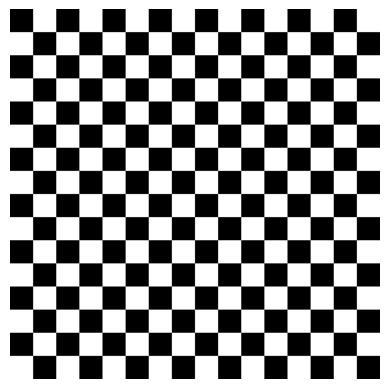

In [2]:
img_rgb = cv2.imread('Image/Some Images/checkerboard1024.tif')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap="gray")
plt.axis('off')

In [3]:
img_gray.shape

(1024, 1024)

In [4]:
'''
This function convert the image into image which will divisible by block size by adding padding to rows and columns
of the image
''' 

def convert_img_div_by_block_size_gray(img__gray, b_s):
    rows, cols = img_gray.shape
#     print(img_gray.shape)
    
    rows_rem = rows % b_s
    cols_rem = cols % b_s
    
    if rows_rem != 0:
        new_rows = rows + (b_s - rows_rem)
    else:
        new_rows = rows
        
    if cols_rem != 0:
        new_cols = cols + (b_s - cols_rem)
    else:
        new_cols = cols
    
    new_img = np.zeros(((new_rows, new_cols)), dtype=np.uint8)
    new_img[:rows, :cols] = img_gray
    
    return new_img

In [5]:
'''
This function initialize the initial dictionary. Keys are tuple and values are integer
(1) = 1 , (2) = 2, (3) = 3, . . . . , (255) = 255
'''

def initialize_dictionary():
    dictionary = dict()
    
    for i in range(256):
        dictionary[(i,)] = i
            
    return dictionary

In [6]:
# Entropy function
def find_entropy(encoded_arr):
    dictionary = dict()
    
    for ele in encoded_arr:
        if ele not in dictionary:
            dictionary[ele] = 1
        else:
            dictionary[ele] = dictionary[ele] + 1
    
    total_px = len(encoded_arr)
    
    entropy = 0
    
    for val in list(dictionary.values()):
        p = val/total_px
        entropy += (p*np.log2(p))
        
    return  -entropy

In [7]:
'''
This is LZW encoder helper function which decode the given single block of the image 
'''
def LZW_encoder_helper(block, code_size):
    dictionary = initialize_dictionary()
        
    idx = 256
    maxi_idx = 1 << code_size

    encoded_out = []

    rows, cols = block.shape

    px_being_proc = (block[0,0],)
    cur_rec_seq = tuple()
              
    for i in range(rows):
        for j in range(cols):
            if i == 0 and j == 0:
                cur_rec_seq = px_being_proc
                continue
            
            px_being_proc = (block[i,j],)        
            new_seq = cur_rec_seq + px_being_proc

            if new_seq not in dictionary:                
                encoded_out.append(dictionary[cur_rec_seq])
                
                if idx <= maxi_idx:
                    dictionary[new_seq] = idx
                    idx += 1  
                cur_rec_seq = px_being_proc
            else:
                cur_rec_seq = new_seq
    encoded_out.append(dictionary[cur_rec_seq])            
    encoded_out = np.array(encoded_out) 
    
    return encoded_out
       

## LZW Encoder

In [8]:
def LZW_encoder(img, block_sz, code_sz):
    
    img_rgb = cv2.imread('Image/Some Images/' + img)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    
    if block_sz == -1:
        block_sz = max(img_gray.shape[0], img_gray.shape[1])
          
    img_gray = convert_img_div_by_block_size_gray(img_gray, block_sz)
    
    rows, cols = img_gray.shape
    num_blocks = (rows*cols) / (block_sz*block_sz)
    
    f = open('img1_lzwcode.txt','w')
    
    f.write(str(rows) + ' ' + str(cols) + ' ' + str(block_sz) + '\n')
    encoded_out_g = []
    
    max_val_code = 0
    num_codes = 0
    compression_ratio = rows * cols 
    avg_len = 0
    entropy = 0
    
    for i in range(0, rows, block_sz):
        for j in range(0, cols, block_sz):
            block = img_gray[i:i+block_sz, j:j+block_sz]
            encoded_out = LZW_encoder_helper(block, code_sz)
            encoded_out_g.append(encoded_out)
            
            # Finding avg length per pixel for one block
            num_encoded_px = len(encoded_out)
            num_encoded_px *= code_sz
            num_encoded_px /= (block_sz * block_sz)
            avg_len += num_encoded_px
            entropy += find_entropy(encoded_out)
            
            temp_max = np.max(encoded_out)
            
            if max_val_code < temp_max:
                max_val_code = temp_max
             
            num_codes += len(encoded_out)
            
            
            for code in encoded_out:
                f.write(str(code) + ' ')
            f.write('\n')    
    
    avg_len /= (num_blocks)
    entropy /= (num_blocks)
    c_r = compression_ratio / (num_codes)
#     print(f"Maximum value of codes = {max_val_code}")
#     print(f"Number of codes = {num_codes}")
#     print(f"Compression Ratio = {c_r}")
#     print(f"Average length per pixel = {avg_len}")
#     print(f"Entropy = {entropy}") 
    
    return encoded_out_g,max_val_code, num_codes, c_r, avg_len, entropy
        

In [9]:
encoded_img, max_val_code, num_codes, c_r, avg_len, entropy = LZW_encoder("checkerboard1024.tif",8, 9)

In [10]:
def convert_file_to_arr(filename): 
    rows, cols, block_sz = 0, 0, 0
    
    with open(filename,'r') as file:
        rows, cols, block_sz = map(int, file.readline().split())
        encoded_integers = []
        for line in file:
            values = line.strip().split()
            encoded_integers.append(list(map(int, values)))
                        
    return rows, cols, block_sz, encoded_integers

In [11]:
def LZW_decoder(filename, code_size):
    rows, cols, block_sz, encoded_arr = convert_file_to_arr(filename)  
    
    if block_sz == -1:
        block_sz = max(rows, cols)
        
    decoded_img = np.zeros((rows,cols))
    
    r,c = 0,0

    for block in range(len(encoded_arr)):
        arr = encoded_arr[block]
               
        dictionary = dict()
        for i in range(0,256):
            dictionary[i] = (i,)
        idx = 256

        result = [] 
        prefix = (arr[0],)
        result.extend(prefix) 
        for code in arr[1:]:
            if code not in dictionary: 
                entry = prefix + (prefix[0],)
            else:
                entry = dictionary[code]
            result.extend(entry) 
            
            if idx <= (1 << code_size):
                dictionary[idx] = prefix + (entry[0],)
                idx += 1
              
            prefix = entry 
          
        
        result = np.array(result).reshape((block_sz, block_sz))
                
        decoded_img[r:r+block_sz, c:c+block_sz] = result
        
        c = c+block_sz
        
        if c >= cols:
            r = r+block_sz
            c = 0
        

    return decoded_img   

In [12]:
decoded_img = LZW_decoder("img1_lzwcode.txt", 9)

(-0.5, 1023.5, 1023.5, -0.5)

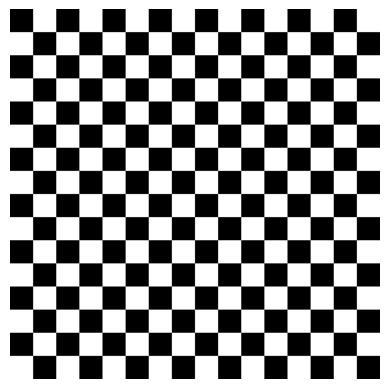

In [13]:
plt.imshow(decoded_img, cmap="gray")
plt.axis('off')

In [ ]:
from prettytable import PrettyTable
  
blc_lst = [4,8,16,32,64,128,256]
code_sz_lst = [9,10,11,12,16]

block_lst = []
for blc in blc_lst:
    a,b,c,d,e = [],[],[],[],[]
    f = []
    print(f"Block size = {blc}")
    myTable = PrettyTable(["Code size", "Max. Val Code", "Number of Code", "Compression Ratio", "Avg. Length", "Entropy"])
    for c_s in code_sz_lst:   
        encoded_img, max_val_code, num_codes, c_r, avg_len, entropy = LZW_encoder("book-cover.tif",blc, c_s)
        myTable.add_row([c_s,max_val_code, num_codes, c_r, avg_len, entropy])
        a.append(max_val_code)
        b.append(num_codes)
        c.append(c_r)
        d.append(avg_len)
        e.append(entropy)
    f.append(a)
    f.append(b)
    f.append(c)
    f.append(d)
    f.append(e)
    block_lst.append(f)
    
    print(myTable)    
    

In [ ]:
for i in range(7):
    plt.plot(code_sz_lst, block_lst[i][2])
plt.title("Compression ratio vs code size w.r.t Block size")    
plt.xlabel("Code size")
plt.ylabel("Compression Ratio")
plt.legend(blc_lst)
plt.show()

In [ ]:
for i in range(7):
    plt.plot(code_sz_lst, block_lst[i][3])
plt.title("Avg. code length vs code size w.r.t Block size")    
plt.xlabel("Code size")
plt.ylabel("Avg. Code Length")
plt.legend(blc_lst)
plt.show()

In [ ]:
for i in range(7):
    plt.plot(code_sz_lst, block_lst[i][4])
plt.title("Entropy vs code size w.r.t Block size")    
plt.xlabel("Code size")
plt.ylabel("Entropy")
plt.legend(blc_lst)
plt.show()

In [ ]:
for i in range(7):
    plt.plot( code_sz_lst, block_lst[i][1])
plt.title("Number of codes vs code size w.r.t Block size")    
plt.xlabel("Code size")
plt.ylabel("Number of codes")
plt.legend(blc_lst)
plt.show()    